# Exploring Pearson correlation and sample size

Correlation skill of decadal hindcasts is very sensitive to verification period, and the commonly applied block-bootstrapping approach for estimating significance doesn't seem to work very well. This notebook explores this issue and compares a few different approaches for estimating significance.

## Assumptions of correlation:
- Normally distributed
- Homoscedastic (variance same for all values of the independent variable)
- Linear relationship
- Continuous variables
- Paired observations
- No outliers

## Inference

### 1) Boostrap

This is the "standard" approach in decadal forecast assessment

### 2) Student t-distribution

For pairs from an uncorrelated bivariate normal distribution, the sampling distribution of the studentized (sample statistic divided by a sample-based estimate standard deviation) Pearson's correlation coefficient follows Student's t-distribution with degrees of freedom n − 2. i.e.

$t = \frac{r}{\sigma_r} = r \sqrt{\frac{n - 2}{1 - r^2}}$

has a student t-distribution in the null case (this is true approximately even in case of non-normal observed values if sample sizes are large enough [1]). This can be used to determine the "critical values" of Pearson correlation coefficient that must be exceeded to be considered non-zero with a given confidence.

In the case of auto-correlated data, it is common to estimate the effective sample size and use this to estimate the critical values (e.g. [2]), though [3] have shown that it is difficult to estimate the effective sample size reliably.

### 3) Bootstrap (frequency domain)

Another documented approach is to bootstrap in the frequency domain [4]

[1] Kendall, M. G., Stuart, A. (1973) The Advanced Theory of Statistics, Volume 2: Inference and Relationship, Griffin. ISBN 0-85264-215-6 (Section 31.19)

[2] https://www.science.org/doi/full/10.1126/science.1143286

[3] https://doi.org/10.1175/1520-0450(1984)023<0800:TIAEOE>2.0.CO;2

[4] https://doi.org/10.1175/1520-0442(1997)010<2147:AMTETS>2.0.CO;2

In [1]:
import cartopy

import regionmask

import numpy as np

import xarray as xr

import seaborn as sns

import xskillscore as xs

import statsmodels.api as sm

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

from src import utils, plot, verify

cartopy.config["pre_existing_data_dir"] = "../../data/cartopy-data"
cartopy.config["data_dir"] = "../../data/cartopy-data"

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
plt.rcParams["figure.figsize"] = (15, 6)

In [4]:
DATA_DIR = "../../data/"

## Let's use the CanESM5 sst data explore the behaviour of the correlation

In [8]:
can = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5.annual.anom_1985-2014.sst_global.zarr"
)
months = np.unique(can.time.dt.month)

had = xr.open_zarr(
    f"{DATA_DIR}/processed/HadISST.annual.anom_1985-2014.sst_global.zarr"
)
had = had.where(had.time.dt.month.isin(months), drop=True)

### To start with, let's focus on a region where there isn't much of a trend for simplicity

In [56]:
def get_lead(ds, lead):
    return ds.sel(lead=lead).swap_dims({"init": "time"})

In [57]:
def get_trend(ds, dim="time"):
    if "member" in ds.dims:
        fit = ds.copy().mean("member")
    else:
        fit = ds.copy()

    return fit.polyfit(dim=dim, deg=1)

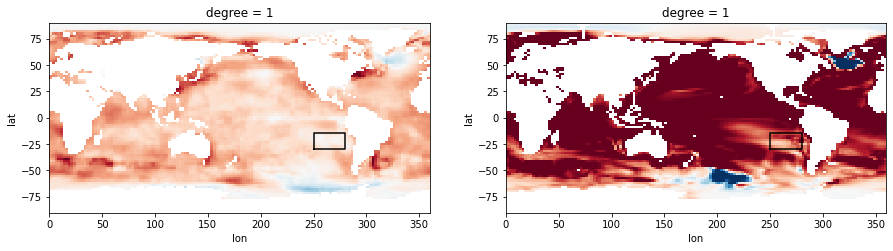

In [13]:
lead = 47

fig = plt.figure(figsize=(15, 3.5))
axs = fig.subplots(1, 2, sharex=True)

vrange = (-5e-19, 5e-19)
get_trend(had)["sst_polyfit_coefficients"].sel(degree=1).plot(
    ax=axs[0], vmin=vrange[0], vmax=vrange[1], cmap="RdBu_r", add_colorbar=False
)
get_trend(get_lead(can, lead))["sst_polyfit_coefficients"].sel(degree=1).plot(
    ax=axs[1], vmin=vrange[0], vmax=vrange[1], cmap="RdBu_r", add_colorbar=False
)

region_name = "ESPSST"
region_box = [250.0, 280.0, -30.0, -15.0]

for ax in axs:
    ax.plot(
        [region_box[0], region_box[1], region_box[1], region_box[0], region_box[0]],
        [region_box[2], region_box[2], region_box[3], region_box[3], region_box[2]],
        "k",
    )

In [14]:
can = {
    "1-year": utils.extract_lon_lat_box(can, region_box, weighted_average=True)
    .rename({"sst": region_name})
    .compute()
}
had = {
    "1-year": utils.extract_lon_lat_box(had, region_box, weighted_average=True)
    .rename({"sst": region_name})
    .compute()
}

Compute some other temporal averages

In [15]:
average = [2, 4, 8]  # years
for av in average:
    can[f"{av}-year"] = utils.rolling_mean(can["1-year"], window_size=av, dim="lead")
    had[f"{av}-year"] = utils.rolling_mean(had["1-year"], window_size=av, dim="time")

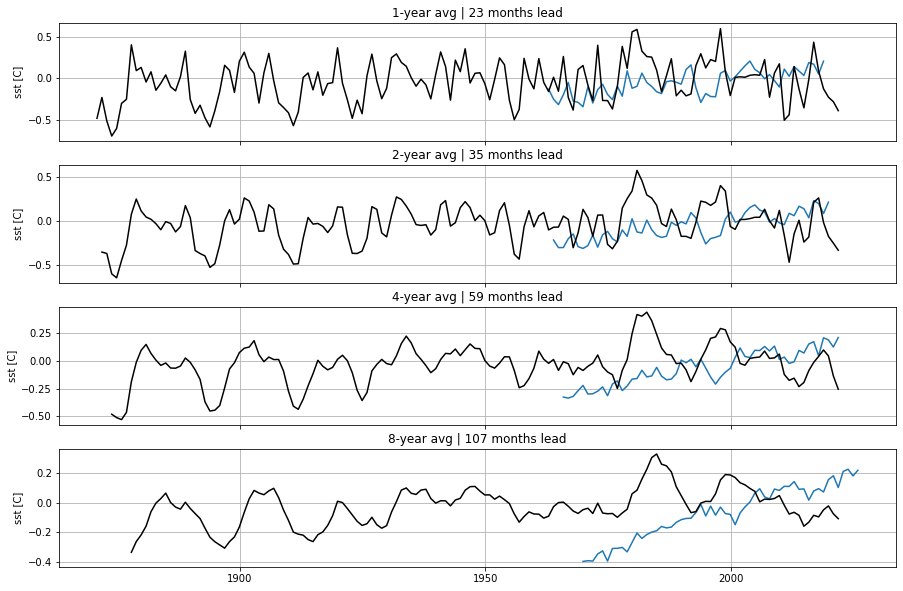

In [16]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(len(can), 1, sharex=True)

for ax, t in zip(axs, can.keys()):
    lead = int(t[0]) * 12 + 11
    get_lead(can[t][region_name].mean("member"), lead).plot(ax=ax)
    had[t][region_name].plot(ax=ax, color="k")
    ax.grid()
    ax.set_title(f"{t} avg | {lead} months lead")
    ax.set_xlabel("")

## How sensitive is the correlation to sample size?

In [165]:
from scipy.signal import detrend as scipy_detrend

In [171]:
def metric_sample_length_sensitivity(*timeseries, blocksize, metric, detrend=False):
    """
    Test the sensitivity of a metric to the sample length by calculating the metric
    on randomly sampled blocks of specified lengths

    Parameters
    ----------
    timeseries: xarray Datasets
        The timeseries required to calculate the metric, e.g. hindcasts and observations
    blocksize: int or list of int
        The blocksize to recalculate the metric for
    metric: str
        The metric to calculate
    detrend: bool
        Whether or not to detrend each block
    """

    def _n_random_block_indices(size, blocksize):
        """
        Returns indices to randomly resample a single block of a specified length multiple
        times from an array.
        """
        block_starts = np.arange(0, size - blocksize + 1)
        increment = np.arange(blocksize)
        return block_starts + np.expand_dims(increment, axis=1)

    def _sample_blocks(*arrays, indices, detrend):
        """Bootstrap the array(s) using the provided indices"""
        blocks = [array[indices] for array in arrays]
        if detrend:
            blocks = [scipy_detrend(b, axis=-2, type="linear") for b in blocks]
        if len(blocks) == 1:
            return blocks[0]
        else:
            return tuple(blocks)

    # Drop nans
    timeseries = [t.dropna("time") for t in timeseries]

    timeseries = xr.align(*timeseries)
    metric = getattr(verify, metric)

    if isinstance(blocksize, int):
        blocksize = [blocksize]

    res = []
    for i, b in enumerate(blocksize):

        indices = _n_random_block_indices(timeseries[0].sizes["time"], b)
        times = timeseries[0].time.values[indices]

        timeseries_blocks = []
        for obj in timeseries:
            timeseries_blocks.append(
                xr.apply_ufunc(
                    _sample_blocks,
                    obj,
                    kwargs=dict(
                        indices=(..., indices),
                        detrend=detrend,
                    ),
                    input_core_dims=[["time"]],
                    output_core_dims=[["time", "sample"]],
                    exclude_dims=set(["time"]),
                    dask="parallelized",
                    dask_gufunc_kwargs=dict(
                        output_sizes={"time": b, "sample": indices.shape[-1]}
                    ),
                    output_dtypes=[obj[list(obj.data_vars)[0]].dtype],
                )
            )

        res.append(
            verify._calculate_metric_from_timeseries(
                *timeseries_blocks, metric=metric, metric_kwargs={}, significance=True
            )
            .assign_coords({"blocksize": ("sample", [b] * indices.shape[-1])})
            .assign_coords({"index": ("sample", [i] * indices.shape[-1])})
            .assign_coords({"block_start": ("sample", times[0, :])})
            .assign_coords({"block_end": ("sample", times[-1, :])})
        )

    return xr.concat(res, dim="sample").to_dataframe()

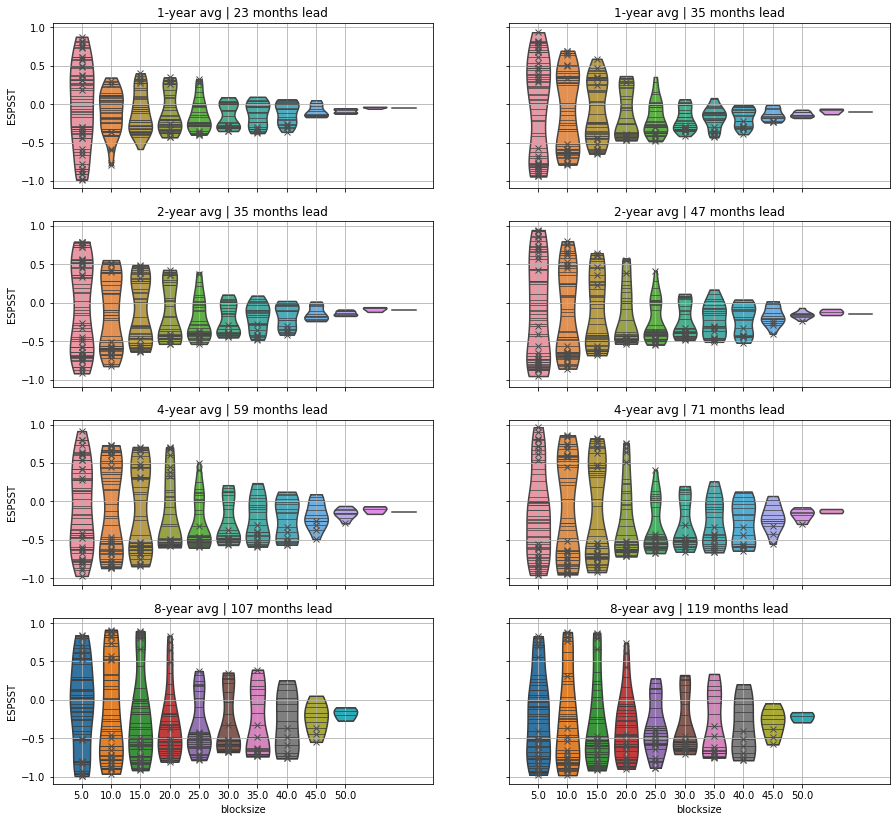

In [375]:
n_leads = 2

fig = plt.figure(figsize=(15, 14))
axs = fig.subplots(len(can), n_leads, sharex=True, sharey=True)

for x, t in enumerate(can.keys()):
    for y, l in enumerate(range(n_leads)):
        lead = (int(t[0]) + l) * 12 + 11
        ax = axs[x, y]
        sens = metric_sample_length_sensitivity(
            get_lead(can[t], lead),
            had[t],
            blocksize=list(range(5, 60, 5)) + [57],
            metric="rXY",
        )

        p = sns.violinplot(
            x="blocksize",
            y=region_name,
            data=sens,
            cut=0,
            inner="stick",
            scale="width",
            ax=ax,
        )
        ax.plot(
            sens["index"][sens[f"{region_name}_signif"]],
            sens[region_name][sens[f"{region_name}_signif"]],
            marker="x",
            linestyle="none",
            color=[0.3, 0.3, 0.3],
        )
        ax.set_title(f"{t} avg | {lead} months lead")
        if x != (len(can) - 1):
            ax.set_xlabel("")
        if y != 0:
            ax.set_ylabel("")
        ax.grid()

### What do these look like for longer periods using the historical simulations?

In [153]:
def remove_trend(ds, dim="time"):
    if "member" in ds.dims:
        fit = ds.copy().mean("member")
    else:
        fit = ds.copy()

    trend = fit.polyfit(dim=dim, deg=1)
    for v in ds.data_vars:
        fit[v] = xr.polyval(ds[dim], trend[f"{v}_polyfit_coefficients"])
    return ds - fit

In [ ]:
can_hist = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_hist.annual.anom_1985-2014.sst_global.zarr"
)
can_hist, _ = xr.align(can_hist, had["1-year"])
can_hist = {
    "1-year": utils.extract_lon_lat_box(
        can_hist,
        region_box,
        weighted_average=True,
    )
    .rename({"sst": region_name})
    .compute()
}

average = [2, 4, 8]  # years
for av in average:
    can_hist[f"{av}-year"] = utils.rolling_mean(
        can_hist["1-year"], window_size=av, dim="time"
    )

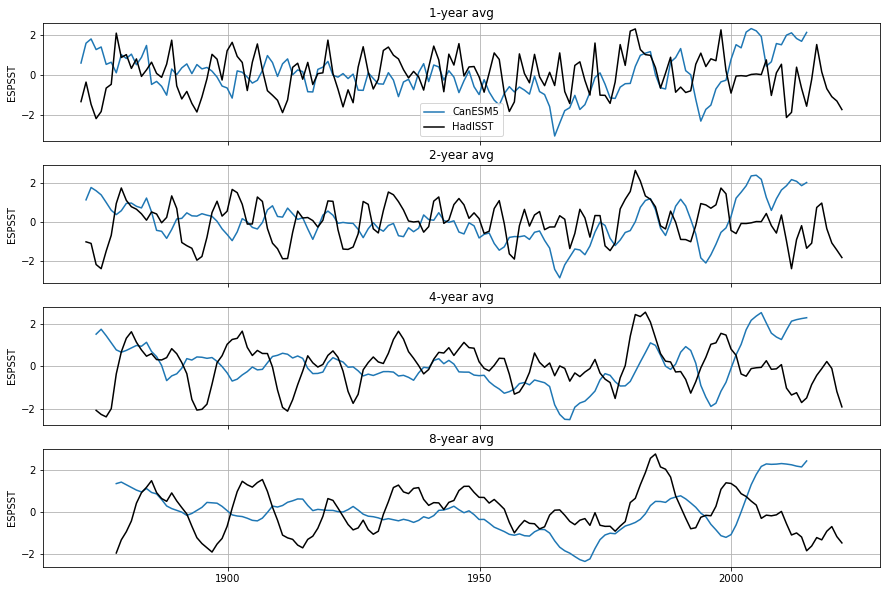

In [52]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(len(can_hist), 1, sharex=True)

for ax, t in zip(axs, can_hist.keys()):
    can_hist_detrended = remove_trend(can_hist[t].mean("member"))[region_name]
    (can_hist_detrended / can_hist_detrended.std("time")).plot(ax=ax, label="CanESM5")

    had_detrended = remove_trend(had[t])[region_name]
    (had_detrended / had_detrended.std("time")).plot(ax=ax, color="k", label="HadISST")

    ax.grid()
    ax.set_title(f"{t} avg")
    ax.set_xlabel("")

_ = axs[0].legend()

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


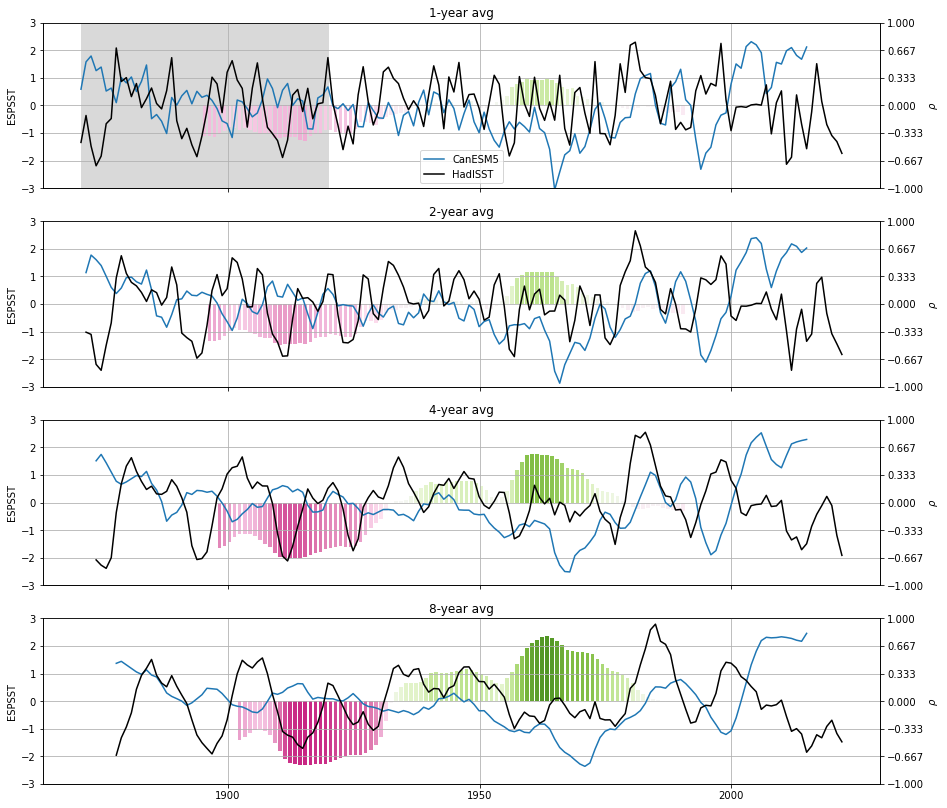

In [328]:
fig = plt.figure(figsize=(15, 14))
axs = fig.subplots(len(can_hist), 1, sharex=True)
block = 50
color_func = interp1d(
    np.linspace(-1, 1, 256), plt.cm.get_cmap("PiYG")(np.linspace(0, 1, 256)), axis=0
)

shade_block = True
for ax, t in zip(axs, can_hist.keys()):
    can_hist_detrended = remove_trend(can_hist[t])
    can_hist_detrended = can_hist_detrended / can_hist_detrended.mean("member").std(
        "time"
    )
    can_hist_detrended[region_name].mean("member").plot(
        ax=ax, label="CanESM5", color="C0"
    )

    had_detrended = remove_trend(had[t])
    had_detrended = had_detrended / had_detrended.std("time")
    had_detrended[region_name].plot(ax=ax, color="k", label="HadISST")

    ax.grid()
    ax.set_ylim(-3, 3)
    ax.set_yticks(np.linspace(-3, 3, 7))
    ax.set_title(f"{t} avg")
    ax.set_xlabel("")

    axt = ax.twinx()
    sens = metric_sample_length_sensitivity(
        can_hist_detrended, had_detrended, blocksize=block, metric="rXY", detrend=True
    )

    axt.bar(
        (sens["block_start"] + ((sens["block_end"] - sens["block_start"]) / 2)).values,
        sens[region_name].values,
        width=0.7 * (sens["block_start"][1] - sens["block_start"][0]),
        color=color_func(sens[region_name].values),
    )
    axt.set_ylim(-1, 1)
    axt.set_yticks(np.linspace(-1, 1, 7))
    axt.set_ylabel(r"$\rho$")

    if shade_block:
        ylims = axt.get_ylim()
        axt.fill_between(
            [sens["block_start"][0], sens["block_end"][0]],
            [ylims[0], ylims[0]],
            [ylims[1], ylims[1]],
            zorder=-1,
            color=[0.85, 0.85, 0.85],
        )
        shade_block = False
        axt.set_ylim(ylims)

    ax.set_zorder(axt.get_zorder() + 1)
    ax.patch.set_visible(False)

_ = axs[0].legend()

### What do the autocorrelation functions look like

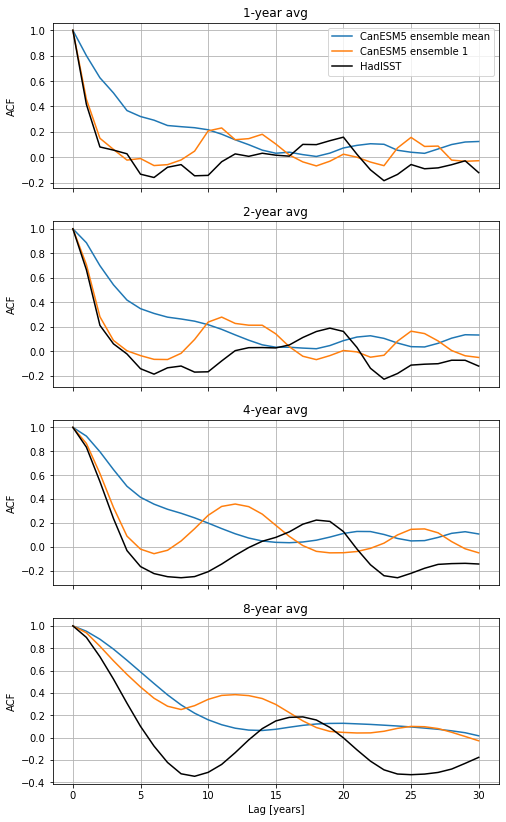

In [259]:
fig = plt.figure(figsize=(8, 14))
axs = fig.subplots(len(can_hist), 1, sharex=True)

for ax, t in zip(axs, can_hist.keys()):
    can_hist_detrended = remove_trend(can_hist[t])[region_name].dropna("time")
    had_detrended = remove_trend(had[t])[region_name].dropna("time")

    can_hist_mean_acf = sm.tsa.acf(can_hist_detrended.mean("member"), nlags=30)
    can_hist_acf = sm.tsa.acf(can_hist_detrended.sel(member=1), nlags=30)
    had_acf = sm.tsa.acf(had_detrended, nlags=30)

    ax.plot(can_hist_mean_acf, label="CanESM5 ensemble mean")
    ax.plot(can_hist_acf, label="CanESM5 ensemble 1")
    ax.plot(had_acf, color="k", label="HadISST")

    ax.grid()
    ax.set_title(f"{t} avg")
    ax.set_ylabel("ACF")

    if t == "8-year":
        ax.set_xlabel("Lag [years]")

axs[0].legend()

In [ ]:
fig = plt.figure(figsize=(8, 16))
axs = fig.subplots(len(can_hist), sharex=True, sharey=True)

for i, t in enumerate(can_hist.keys()):
    ax = axs[i]
    sens = metric_sample_length_sensitivity(
        remove_trend(can_hist[t]),
        remove_trend(had[t]),
        blocksize=list(range(30, 70, 10)) + [145],
        metric="rXY",
    )

    p = sns.violinplot(
        x="blocksize",
        y=region_name,
        data=sens,
        cut=0,
        inner="stick",
        scale="width",
        ax=ax,
    )
    ax.plot(
        sens["index"][sens[f"{region_name}_signif"]],
        sens[region_name][sens[f"{region_name}_signif"]],
        marker="x",
        linestyle="none",
        color=[0.3, 0.3, 0.3],
    )
    ax.set_title(f"{t} avg")
    ax.grid()

In [267]:
from statsmodels.tsa.ar_model import AutoReg

### How do things look for independent pseudo-random realizations drawn from a Gaussian distribution?

In [316]:
time = xr.cftime_range(start="1001", end="5000", freq="AS")
a = {
    "1-year": xr.DataArray(
        np.random.normal(loc=0.0, scale=1.0, size=len(time)), coords={"time": time}
    ).to_dataset(name=region_name)
}
b = {
    "1-year": xr.DataArray(
        np.random.normal(loc=0.0, scale=1.0, size=len(time)), coords={"time": time}
    ).to_dataset(name=region_name)
}

In [318]:
average = [2, 4, 8]  # years
for av in average:
    a[f"{av}-year"] = utils.rolling_mean(
        a["1-year"], window_size=av, dim="time"
    ).dropna("time")
    b[f"{av}-year"] = utils.rolling_mean(
        b["1-year"], window_size=av, dim="time"
    ).dropna("time")

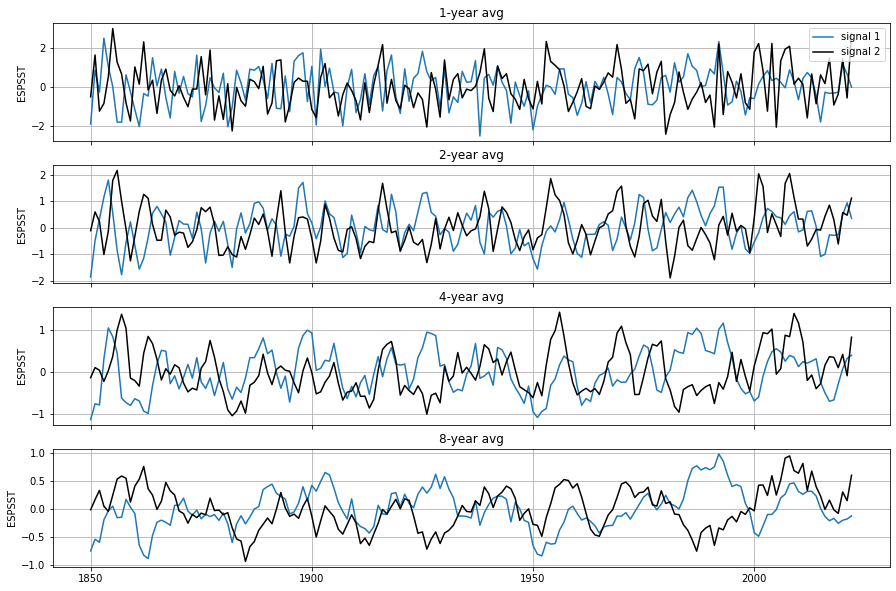

In [320]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(len(a), 1, sharex=True)

for ax, t in zip(axs, can_hist.keys()):
    a[t][region_name].sel(time=slice("1850", "2022")).plot(ax=ax, label="signal 1")
    b[t][region_name].sel(time=slice("1850", "2022")).plot(
        ax=ax, color="k", label="signal 2"
    )

    ax.grid()
    ax.set_title(f"{t} avg")
    ax.set_xlabel("")

_ = axs[0].legend()

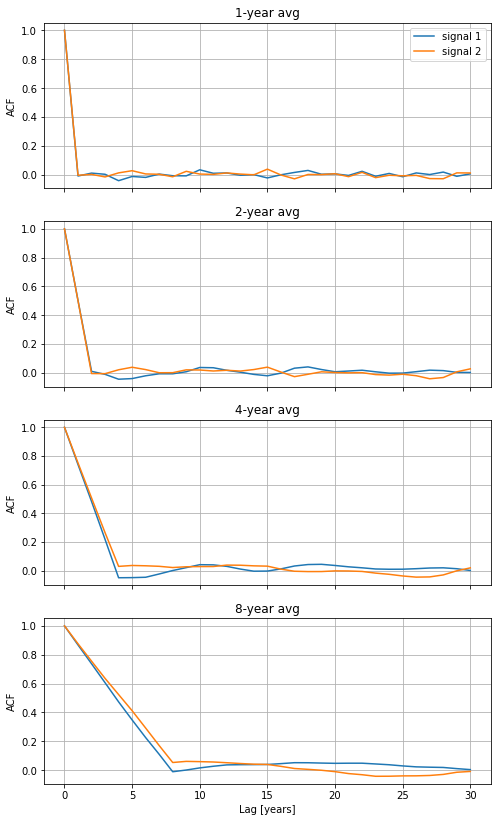

In [321]:
fig = plt.figure(figsize=(8, 14))
axs = fig.subplots(len(can_hist), 1, sharex=True)

for ax, t in zip(axs, can_hist.keys()):
    a_acf = sm.tsa.acf(a[t][region_name], nlags=30)
    b_acf = sm.tsa.acf(b[t][region_name], nlags=30)

    ax.plot(a_acf, label="signal 1")
    ax.plot(b_acf, label="signal 2")

    ax.grid()
    ax.set_title(f"{t} avg")
    ax.set_ylabel("ACF")

    if t == "8-year":
        ax.set_xlabel("Lag [years]")

axs[0].legend()

In [324]:
sens = metric_sample_length_sensitivity(
    a[t].expand_dims("member"),
    b[t],
    blocksize=[50],  # list(range(30, 70, 10)) + [145],
    metric="rXY",
)

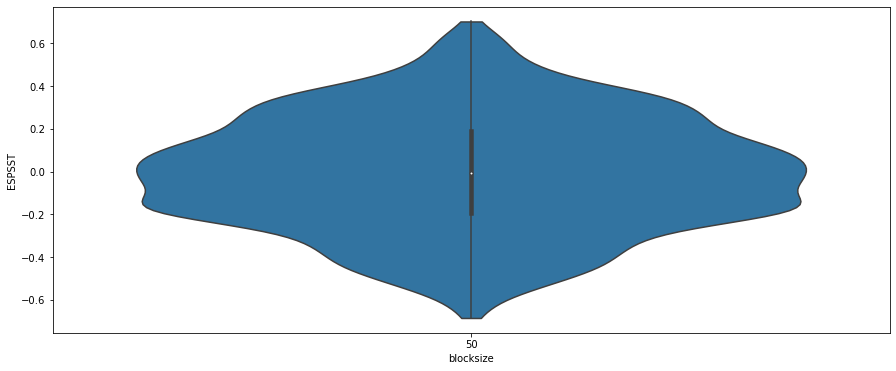

In [327]:
p = sns.violinplot(
    x="blocksize",
    y=region_name,
    data=sens,
    cut=0,
    scale="width",
)

In [ ]:
fig = plt.figure(figsize=(8, 16))
axs = fig.subplots(len(can_hist), sharex=True, sharey=True)

for i, t in enumerate(can_hist.keys()):
    ax = axs[i]
    sens = metric_sample_length_sensitivity(
        a[t],
        b[t],
        blocksize=list(range(30, 70, 10)) + [145],
        metric="rXY",
    )

    p = sns.violinplot(
        x="blocksize",
        y=region_name,
        data=sens,
        cut=0,
        inner="stick",
        scale="width",
        ax=ax,
    )
    ax.plot(
        sens["index"][sens[f"{region_name}_signif"]],
        sens[region_name][sens[f"{region_name}_signif"]],
        marker="x",
        linestyle="none",
        color=[0.3, 0.3, 0.3],
    )
    ax.set_title(f"{t} avg")
    ax.grid()

# What about using historical data verified against control run data?

In [324]:
hist = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_hist.annual.anom_1985-2014.precip_global.zarr"
)
ctrl = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.precip_global.zarr"
)
ctrl = ctrl.assign_coords({"time": ctrl.get_index("time").shift(-3700, freq="12MS")})

var_name = "precip"

In [325]:
regions = regionmask.defined_regions.giorgi.mask(hist)
region_indices = regionmask.defined_regions.giorgi.map_keys(["Australia"])
mask = regions.isin(region_indices)

In [326]:
ctrl

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144, time: 1051)
Coordinates:
    area     (lat, lon) float32 dask.array<chunksize=(10, 12), meta=np.ndarray>
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) object 1850-12-01 00:00:00 ... 2900-12-01 00:00:00
    zsurf    (lat, lon) float32 dask.array<chunksize=(10, 12), meta=np.ndarray>
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1051, 10, 12), meta=np.ndarray>

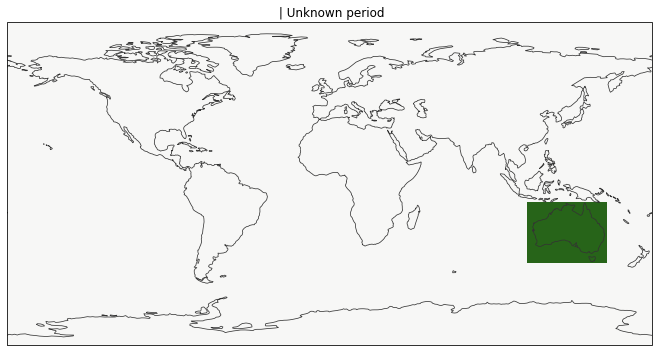

In [301]:
_ = plot.metric_maps(
    [[mask.to_dataset(name="mask")]],
    "mask",
    vrange=(0, 1),
    add_colorbar=False,
    central_longitude=0,
    figsize=(10, 5),
)

In [302]:
def weighted_average(ds):
    return ds.weighted(ds.area).mean(["lon", "lat"])

In [303]:
model = {"1-year": weighted_average(hist.where(mask)).compute()}

obsv = {"1-year": weighted_average(ctrl.where(mask)).compute()}

average = [2, 4, 8]  # years
for av in average:
    model[f"{av}-year"] = utils.rolling_mean(
        model["1-year"], window_size=av, dim="time"
    )
    obsv[f"{av}-year"] = utils.rolling_mean(obsv["1-year"], window_size=av, dim="time")

In [304]:
a = (
    model["8-year"]
    .mean("member")
    .sel(time=slice("1960", "2014"))[var_name]
    .dropna("time")
    .values
)
b = obsv["8-year"][var_name].dropna("time").values

nc = len(b) - len(a)
c = np.zeros(nc)
for i in range(nc):
    c[i] = pearsonr(a, b[i : len(a) + i])[0]

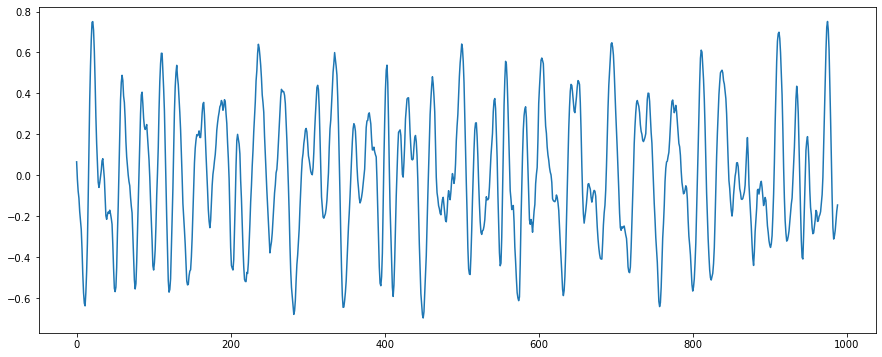

In [305]:
plt.plot(c)

In [306]:
np.argmax(c)

975

KeyError: "not all values found in index 'time'"

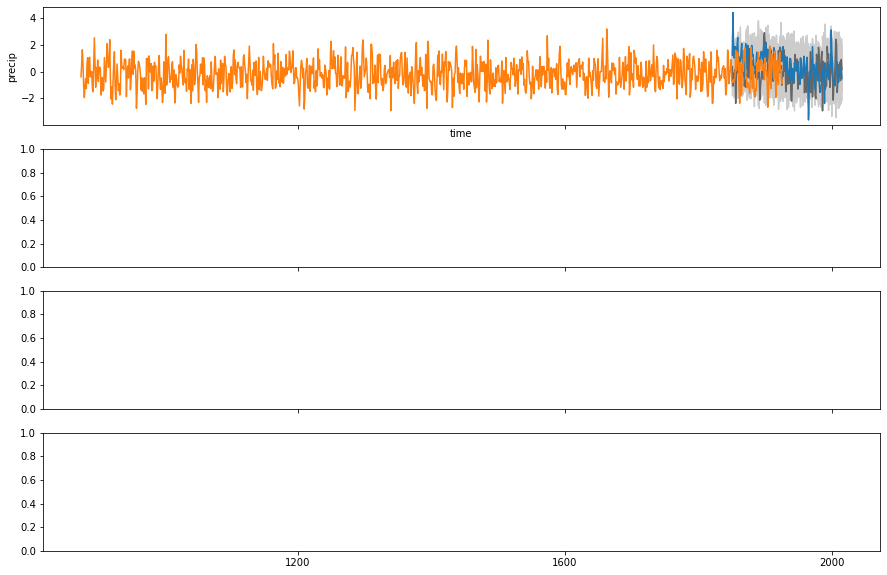

In [307]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(len(model), 1, sharex=True)

for ax, t in zip(axs, model.keys()):
    model_member_norm = (model[t] / model[t].std(["member", "time"]))[var_name]
    model_member_norm.plot.line(
        ax=ax, x="time", label="__nolabel__", color=[0.8, 0.8, 0.8], add_legend=False
    )
    model_member_norm.sel(member=1).plot(
        ax=ax, label="Model ensemble 1", color=[0.4, 0.4, 0.4]
    )

    model_mean_norm = (model[t].mean("member") / model[t].mean("member").std("time"))[
        var_name
    ]
    model_mean_norm.plot(ax=ax, label="Model ensemble mean", color="C0")

    obsv_norm = (obsv[t] / obsv[t].std("time"))[var_name]
    obsv_norm.plot(ax=ax, color="C1", label="Observations")

    print(np.correlate(model_mean_norm, obsv_norm.sel(time=model_mean_norm.time)))

    ax.text(
        0.01,
        0.90,
        f"Rxy = {xs.pearson_r(model_mean_norm, obsv_norm.sel(time=model_mean_norm.time), dim='time', skipna=True).values:.2f}",
        transform=ax.transAxes,
    )

    ax.grid()
    ax.set_title(f"{t} avg")
    ax.set_xlabel("")
    ax.set_xlim(
        xr.cftime_range(
            "1850-01-01",
            "2015-12-31",
            periods=2,
            freq=None,
            calendar=obsv[t].time.dt.calendar,
        )
    )

_ = axs[0].legend()

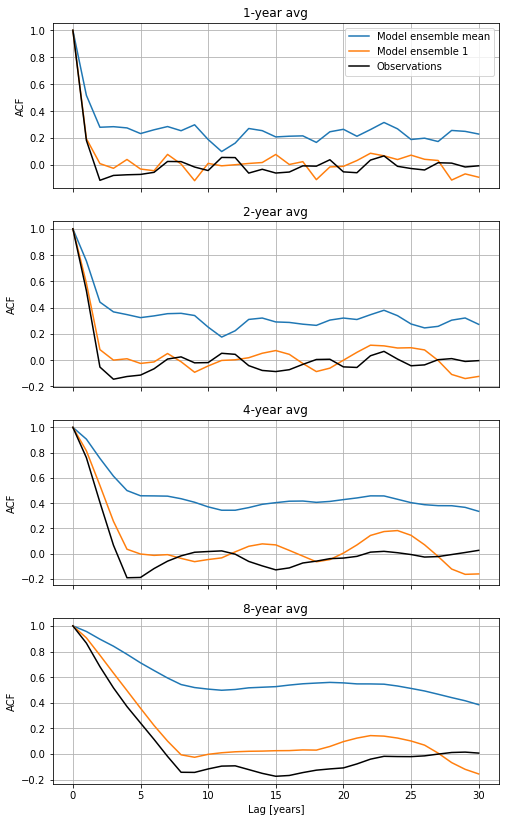

In [221]:
fig = plt.figure(figsize=(8, 14))
axs = fig.subplots(len(model), 1, sharex=True)

for ax, t in zip(axs, model.keys()):
    model_plot = model[t][var_name].dropna("time")
    obsv_plot = obsv[t][var_name].dropna("time")

    model_mean_acf = sm.tsa.acf(model_plot.mean("member"), nlags=30)
    model_acf = sm.tsa.acf(model_plot.sel(member=1), nlags=30)
    obsv_acf = sm.tsa.acf(obsv_plot, nlags=30)

    ax.plot(model_mean_acf, label="Model ensemble mean")
    ax.plot(model_acf, label="Model ensemble 1")
    ax.plot(obsv_acf, color="k", label="Observations")

    ax.grid()
    ax.set_title(f"{t} avg")
    ax.set_ylabel("ACF")

    if t == "8-year":
        ax.set_xlabel("Lag [years]")

axs[0].legend()